## Lista 1 - Aprendizagem de máquina probabilístico
- Aluno: Lucas Rodrigues Aragão - Graduação 538390

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from scipy.stats import beta

### Questão 1
A moeda jogada 10 vezes, em que 8 vezes dá cara

#### a) calcular a probabilidade $\theta$

In [4]:
def thetaML(n1,n):
    return n1/n

def thetaMap(n1,n,a,b):
    return (a+n1-1)/(a+b+n-2)

def expectedTheta(n1,n,a,b):
    return (a+n1)/(a+b+n)

def likelihood(theta, n,n1):
    return (theta**n1) * (1- theta)**(n-n1)

In [5]:
n = 10
n1 = 8

Solução de máxima verossimilhança - ML 

$$\theta_{ML} = \argmax \space p(\mathcal{D| \theta})$$

$$\theta_{ML} = \frac{N_1}{N}$$

In [6]:
thetaML(n1, n)

0.8

Solução de máximo a posteriori - MAP

 $$\theta_{MAP} = arg \space max \space p(\theta|\mathcal{D}) = arg \space max \space p(\mathcal{D}|\theta) p(\theta) $$

$$\theta_{MAP} = \frac{a+N_1-1}{a+b+N-2}$$

In [7]:
thetaMap(n1=n1, n=n, a=1,b=1)

0.8

Solução bayesiana 

$$p(\theta| \mathcal{D}) = \frac{p(\mathcal{D}|\theta)p(\theta)}{p(\mathcal{D})} = \frac{p(\mathcal{D}|\theta) p(\theta)}{\int{p(\mathcal{D}|\theta)p(\theta) d \theta}}$$

$$\mathbb{E}[\theta|\mathcal{D}] = \frac{a+N_1}{a+b+N}$$

In [8]:
expectedTheta(n1=n1, n=n, a=1,b=1)

0.75

#### b) Plotar as distribuições do modelo e a verossimilhança, considerando:
 
$$p(\theta) = Beta(\theta |a=1, b=1)$$


$$p(\theta) = Beta(\theta |a=2, b=2)$$

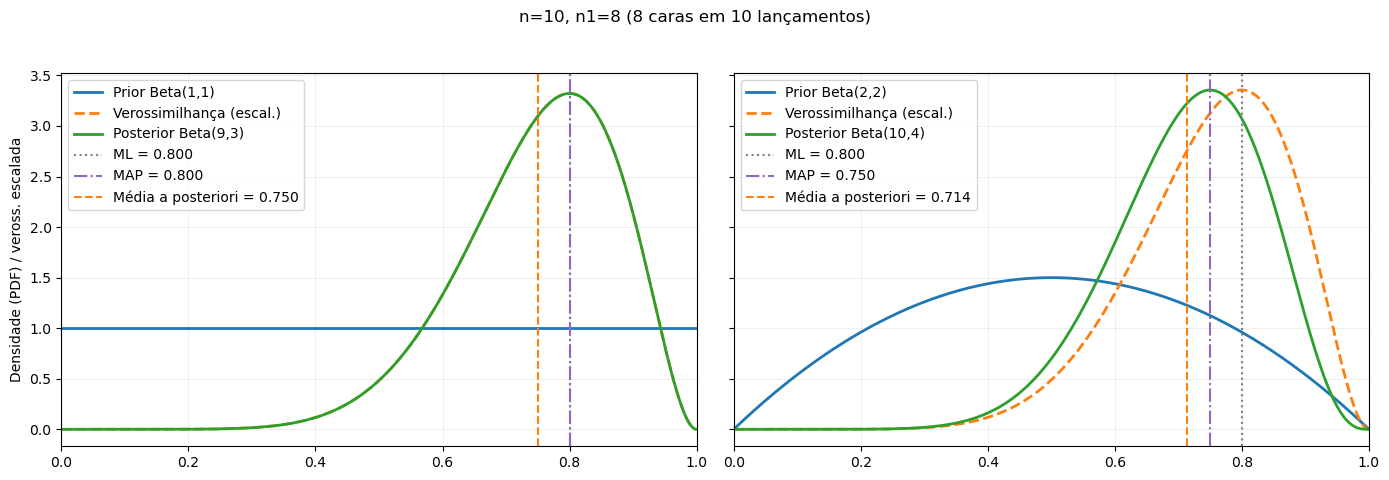

In [9]:
theta = np.linspace(0, 1, 1000)
prioris = [(1,1), (2,2)]
fig, axes = plt.subplots(1, 2, figsize=(14,5), sharey=True)


for ax,(a,b) in zip(axes, prioris):
    priori_pdf = beta.pdf(theta,a,b)
    like = likelihood(theta,n,n1)

    posteriori_pdf = beta.pdf(theta, a + n1, b + n - n1)
    
    like_scaled = like * (posteriori_pdf.max() / like.max())
    
    ax.plot(theta, priori_pdf, label=f'Prior Beta({a},{b})', linewidth=2)
    ax.plot(theta, like_scaled, '--', label='Verossimilhança (escal.)', linewidth=2)
    ax.plot(theta, posteriori_pdf, label=f'Posterior Beta({a+n1},{b+n-n1})', linewidth=2)
    
    t_ml = thetaML(n1,n)
    t_map = thetaMap(n1,n,a,b)
    exp_t = expectedTheta(n1,n,a,b)

    ax.axvline(t_ml, color='gray', linestyle=':', label=f'ML = {t_ml:.3f}')
    ax.axvline(t_map, color='tab:purple', linestyle='-.', label=f'MAP = {t_map:.3f}')
    ax.axvline(exp_t, color='tab:orange', linestyle='--', label=f'Média a posteriori = {exp_t:.3f}')
   
    ax.set_xlim(0,1)
    ax.grid(alpha=0.2)
    ax.legend(loc='upper left')

axes[0].set_ylabel('Densidade (PDF) / veross. escalada')
plt.suptitle(f'n={n}, n1={n1} (8 caras em 10 lançamentos)')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### Questão 2
Implementar um modelo Bernoulli Naive Bayes Bayesiano

Como no dataset, temos 3 classes de review, positivas, neutras e negativas, devemos usar uma distribuição multinoulli (categórica).

$$p(x_d|y = c, \theta_{dc}) = Cat(x_d|\theta_{dc}) = \prod^{K}_{k=1} \theta^{x_{dk}}_{dck}$$

Seja $\pi = [\pi_1, \cdots , \pi_c]^T$, o vetor de probabilidades a piori das classes

Para a predição temos

$$\bar{\theta}_{dc} = \frac{N_{dc} + b }{N_c + a +b}$$

$$\bar{\pi}_c = \frac{N_c + \alpha_c}{N + \sum_{c=1}^C \alpha_c}$$

E a classe predita $\hat{y}_*$ é dada por:

$$\hat{y}_* = \argmax_c [\bar{\pi}_c \prod_{d=1}^D (\bar{\theta}_{dc})^{\mathbb{I(x_{*d} = 1)}} (1-\bar{\theta}_{dc})^{\mathbb{I(x_{*d} = 0)}} ]$$

Que ao aplicar convenções é dada por 

$$\hat{y}_* = \argmax_c[\log{\bar{\pi}_c }  + \sum_{d|x_{*d} = 1}{\log{\bar{\theta}_{dc}}} + \sum_{d|x_{*d} = 0}{\log{(1 -\bar{\theta}_{dc}})} ]$$

In [ ]:
class BernoulliNB_Bayesian:
    def __init__(self, alpha_a=1.0, alpha_b=1.0):
        self.alpha_a = alpha_a
        self.alpha_b = alpha_b

    def fit(self, X, y):
        self.classes_ = np.unique(y)
        n_features = X.shape[1]
        self.theta_ = {}
        self.class_log_prior_ = {}
        
        for c in self.classes_:
            X_c = X[y == c]
            N_c = X_c.shape[0]
            N_cj = np.array(X_c.sum(axis=0)).flatten()
            self.theta_[c] = (self.alpha_a + N_cj) / (self.alpha_a + self.alpha_b + N_c)
            self.class_log_prior_[c] = np.log(N_c / X.shape[0])
    
    def predict(self, X):
        predictions = []
        for i in range(X.shape[0]):
            log_probs = {}
            x_i = X[i].toarray().flatten()
            for c in self.classes_:
                theta_c = self.theta_[c]
                log_prob = self.class_log_prior_[c] + np.sum(
                    x_i * np.log(theta_c) + (1 - x_i) * np.log(1 - theta_c)
                )
                log_probs[c] = log_prob
            predictions.append(max(log_probs, key=log_probs.get))
        return np.array(predictions)


In [ ]:
# Carregar dados
data = pd.read_csv("cleaned_reviews.csv").dropna()

# Codificar labels
y = LabelEncoder().fit_transform(data['sentiments'])
X_text = data.iloc[:, 1]  

def sample_split(X_text, y, n_train=1000):
    indices = np.random.permutation(len(y))
    train_idx = indices[:n_train]
    test_idx = indices[n_train:]
    x_train, y_train = X_text.iloc[train_idx], y[train_idx]
    x_test, y_test = X_text.iloc[test_idx], y[test_idx]

    encoder = CountVectorizer(binary=True).fit(x_train)
    x_train_enc = encoder.transform(x_train)
    x_test_enc = encoder.transform(x_test)
    
    return x_train_enc, y_train, x_test_enc, y_test, encoder


In [12]:
priors = [(1,1), (0.5,0.5), (2,2)]
n_repeats = 20
n_train = 1000

for a,b in priors:
    accs = []
    for _ in range(n_repeats):
        X_train, y_train, X_test, y_test, _ = sample_split(X_text, y, n_train=n_train)
        model = BernoulliNB_Bayesian(alpha_a=a, alpha_b=b)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accs.append(accuracy_score(y_test, y_pred))
    
    print(f"Prior Beta({a},{b}): mean acc = {np.mean(accs):.4f}, std = {np.std(accs):.4f}")


Prior Beta(1,1): mean acc = 0.6704, std = 0.0259
Prior Beta(0.5,0.5): mean acc = 0.6457, std = 0.0267
Prior Beta(2,2): mean acc = 0.6956, std = 0.0193
